In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from figure_utils import journal_figure, nanmad
import stats as my_stats

In [ ]:
model_list = ["alexnet_relu", "convnext", "convnext_ssl", "resnet18", "resnet18_robust", "resnet18_ssl", "resnet", "resnet_ssl", "resnet_swsl", "resnetSIN", "resnet152_2", "resnet101", "resnet101_ssl", "resnet_robust_eps1", "resnet_robust_eps3", "inception", "inceptionv1", "vit", "vit_ssl", "vgg16", "vgg16_robust", "densenet", "densenet169", "densenet161", "densenet161_robust", "densenet121", "mobilenet", "mobilenet_v2", "mobilenet_robust", "squeezenet", "cornetS_t0", "cornetS_reg", "cornetRT_t4", "nasnet", "pnasnet", "swin", "swin_ssl", "shufflenet", "shufflenet_robust"]


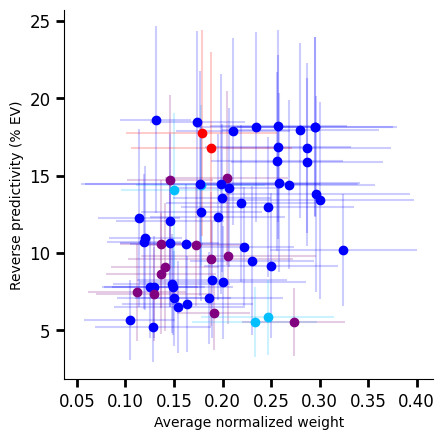

In [25]:
avg_weights = []
evs_reversed = []

avg_weights_cnn = []
evs_reversed_cnn = []

for m, model in enumerate(model_list):
    if "ssl" in model:
        color="purple"
    elif model == "vit" or model=="swin":
        color="deepskyblue"
    elif "reg" in model:
        color="red"
    else:
        color="blue"
    if "robust" not in model:
        for monkey in ["magneto", "nano"]:
            weights = np.load(f"./weights_prediction/{model}_to_{monkey}_ridge_weights_avg.npy")

            weights = np.nanmean(np.abs(weights), axis=0)

            norm_weights = weights / np.max(weights)
            avg_weights.append(np.nanmean(norm_weights))
            ev_reversed = np.load(f'./results_predictions/monkey2model/{monkey}/ev_{model}.npy')
            evs_reversed.append(np.nanmean(ev_reversed))

            if model != "cornetS_reg2" and "ssl" not in model and "robust" not in model and model != "vit" and model !="swin":

                evs_reversed_cnn.append(np.nanmean(ev_reversed))
                avg_weights_cnn.append(np.nanmean(norm_weights))


            plt.errorbar(np.nanmean(norm_weights), np.nanmean(ev_reversed),
                        xerr=nanmad(norm_weights), yerr=nanmad(ev_reversed),
                        alpha=0.2, color=color, zorder=5)
            plt.scatter(np.nanmean(norm_weights), np.nanmean(ev_reversed), alpha=1, label=model if monkey=="magneto" else None, color=color, zorder=15)

plt.xlabel("Average normalized weight")
plt.ylabel("Reverse predictivity (% EV)")
journal_figure()


In [14]:
my_stats.nancorr(avg_weights, evs_reversed, "spearman")

r(63) = 0.40, p = 0.001


(np.float64(0.3988553113553113), np.float64(0.0010963009460897939))

In [15]:
my_stats.nancorr(avg_weights_cnn, evs_reversed_cnn, "spearman")

r(47) = 0.51, p = < 0.001


(np.float64(0.5133521493703864), np.float64(0.00019049334332466277))

In [16]:
from matplotlib.colors import LinearSegmentedColormap

# Define custom colormap from white → #00aeef → #21409A
custom_cmap = LinearSegmentedColormap.from_list(
    "white_to_deep_blue", ['#FFFFFF', '#00aeef', '#21409A'], N=50
)

def color_by_bin_position(i, total_bins):
    return custom_cmap(i / (total_bins - 1))

In [17]:
def new_journal_figure(ax=None, do_save=False, filename='figure.eps', dpi=300, size_inches=(2.16, 2.16), linewidth=1, set_aspect=False):
    """
    Adjusts a matplotlib axis to make it look publication-worthy.
    """
    if ax is None:
        ax = plt.gca()

    ax.tick_params(direction='out', length=6, width=linewidth)

    # Turn off the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Only set aspect if explicitly asked (not EPS-safe with multiple axes)
    if set_aspect:
        try:
            ax.set_aspect(1.0 / ax.get_data_ratio(), adjustable='box')
        except Exception as e:
            print("Aspect ratio setting skipped due to:", e)

    # Set font style
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(12)
        label.set_fontname('Times New Roman')


Mean EV (Model → Monkey): 54.62 +/- 10.74
Mean EV (Monkey → Model): 16.87 +/- 5.96


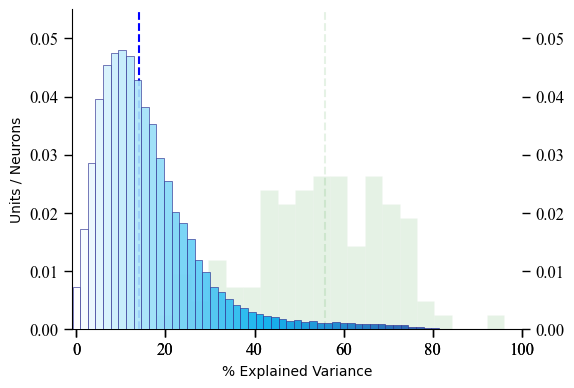

Mean EV (Model → Monkey): 53.00 +/- 10.22
Mean EV (Monkey → Model): 5.66 +/- 2.57


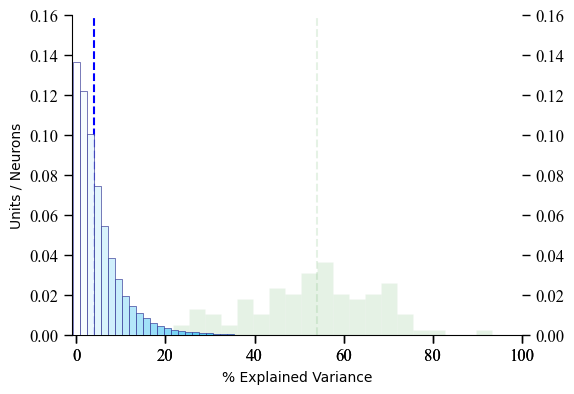

In [22]:
for model in ['densenet161', 'vgg16']:
    out_dir = f'./results_predictions/model2monkey/{model}/'
    for monkey in ["nano"]:
        bins = 30
        lim = 0.16 if model=="vgg16" else 0.055
        out_dir_reversed = f'./results_predictions/monkey2model/{monkey}/'

        ev_per_neuron = np.load(os.path.join(out_dir, f'ev_{monkey}.npy')).flatten()
        ev_per_neuron_reversed = np.load(os.path.join(out_dir_reversed, f'ev_{model}.npy')).flatten()
        ev_per_neuron_reversed = np.nan_to_num(ev_per_neuron_reversed)

        fig = plt.figure(figsize=(6, 4))
        ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.8])
        ax2 = fig.add_axes([0.1, 0.1, 0.75, 0.8], frameon=False)
        ax2.yaxis.tick_right()
        ax2.yaxis.set_label_position('right')
        ax2.set_ylim(0,lim)


        # === Histogram for forward EV (Model → Monkey) ===
        ax1.hist(ev_per_neuron, bins=20, alpha=0.1, edgecolor='white', density=True,
                 color='green', label='Model → Monkey')
        ax1.axvline(np.nanmedian(ev_per_neuron), color="green", linestyle="--", alpha=0.1)
        print(f"Mean EV (Model → Monkey): {np.nanmean(ev_per_neuron):.2f} +/- {nanmad(ev_per_neuron):.2f}")
        ax1.set_xlabel("% Explained Variance")
        ax1.set_ylabel("Units / Neurons", color='black')
        ax1.tick_params(axis='y', labelcolor='black')
        ax1.set_ylim(0, lim)
        ax1.set_xlim(-1,100)
        ax2.set_xlim(-1,100)

        # === Histogram for reversed EV (Monkey → Model) ===
        counts, bin_edges = np.histogram(ev_per_neuron_reversed, bins=50, density=True)
        bin_width = bin_edges[1] - bin_edges[0]
        for i in range(len(counts)):
            ax2.bar(bin_edges[i], counts[i], width=bin_width,
                    color=color_by_bin_position(i, len(counts)),
                    edgecolor='#2e3192', linewidth=0.5, alpha=0.9)
        ax1.axvline(np.median(ev_per_neuron_reversed), color="blue", linestyle="--", zorder=1)
        print(f"Mean EV (Monkey → Model): {np.mean(ev_per_neuron_reversed):.2f} +/- {nanmad(ev_per_neuron_reversed):.2f}")

        # === Style both axes using journal_figure ===
        new_journal_figure(ax1, set_aspect=False)
        new_journal_figure(ax2, set_aspect=False)
        
        plt.show()
        plt.close()

In [24]:
ev_per_neuron_vgg16 = np.load(os.path.join(out_dir_reversed, f'ev_vgg16.npy')).flatten()
ev_per_neuron_vgg16 = np.nan_to_num(ev_per_neuron_vgg16)
ev_per_neuron_densenet161= np.load(os.path.join(out_dir_reversed, f'ev_densenet161.npy')).flatten()

my_stats.print_unpaired_test(ev_per_neuron_vgg16, ev_per_neuron_densenet161)

z = -229.139, p < 0.001


/opt/homebrew/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 100352.
  res = hypotest_fun_out(*samples, **kwds)


np.float64(0.0)